# Grab largest transformations from kinesin series

In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import csv
import numpy as np
from rdkit.Chem import PandasTools

from rdkit import Chem
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles
from rdkit.Chem.rdRGroupDecomposition import RGroupDecomposition, RGroupDecompositionParameters
from rdkit.Chem import rdRGroupDecomposition
rg_params = RGroupDecompositionParameters()
rg_params.onlyMatchAtRGroups = True
from rdkit.Chem.Draw import DrawingOptions
DrawingOptions.atomLabelFontSize = 55
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3.0
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_useSVG=True
from IPython.display import display
from PIL import Image

In [2]:
def get_concat_h(im1, im2):
    """construct concatenated image"""
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [3]:
# grab list of all possible transformations:
fully_connected = list(itertools.combinations(glob.glob("ligands/*.pdb"), 2))

# for each transformation, count difference in number of heavy atoms after MCS subtraction:
transforms = []
handled_perts = []
perts_w_scores = []
for pert in fully_connected:
    pert_name = pert[0]+"~"+pert[1]
    handled_perts.append(pert_name)
    
    # make sure we don't do perts both ways:
    if pert[1]+"~"+pert[0] not in handled_perts:

        ligA = rdmolfiles.MolFromPDBFile(pert[0])
        ligB = rdmolfiles.MolFromPDBFile(pert[1])

        mcs = rdFMCS.FindMCS([ligA, ligB])

        fragA = Chem.ReplaceCore(ligA, Chem.MolFromSmarts(mcs.smartsString))
        fragB = Chem.ReplaceCore(ligB, Chem.MolFromSmarts(mcs.smartsString))

        fragA_smiles = Chem.MolToSmiles(fragA)
        fragB_smiles = Chem.MolToSmiles(fragB)

        # assign a score based on n_ha transformed:
        transform_score = 0
        for frag_A, frag_B in itertools.zip_longest(fragA_smiles.split("."), fragB_smiles.split(".")):
            if frag_A == None:
                fragA_atoms = "X"
            elif frag_B == None:
                fragB_atoms == "X"
            else:
                fragA_atoms = frag_A[4:].replace("(", "").replace(")", "").replace("+", "").replace("-", "")
                fragB_atoms = frag_B[4:].replace("(", "").replace(")", "").replace("+", "").replace("-", "")


            if len(fragA_atoms) == len(fragB_atoms):
                transform_score += 1
            elif len(fragA_atoms) != len(fragB_atoms):
                if len(fragA_atoms) > len(fragB_atoms):
                    transform_score += len(fragA_atoms)
                else:
                    transform_score += len(fragB_atoms)
        # try to see if we have >2 R-groups changing, if so, set transform_score to 0:
        # this way we end up with mainly perturbations that transform the long tail.
        if len(fragA_smiles.split(".")) > 2 or len(fragB_smiles.split(".")) > 2:
            transform_score = 0

        transforms.append([ligA, ligB, pert[0], pert[1], transform_score])
        
        #print(fragA_smiles, "------->", fragB_smiles, transform_score, "\n")
        perts_w_scores.append([fragA_smiles, fragB_smiles, pert[0], pert[1], transform_score])


In [4]:
with open("ligands/perts_w_scores.csv", "w") as writefile:
    writer = csv.writer(writefile)
    for row in perts_w_scores:
        writer.writerow(row)

## Check R-groups:

code based on https://rdkit.blogspot.com/2020/10/molecule-highlighting-and-r-group.html

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize=(450,350)
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdqueries
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)
import pandas as pd
import glob

from IPython.display import SVG,Image
from ipywidgets import interact

import rdkit
print(rdkit.__version__)

2020.09.1


In [6]:
ms = [ Chem.MolFromMol2File(path) for path in glob.glob("ligands/*.mol2") ]
cids = [ path.replace("ligands/","").replace(".mol2","") for path in glob.glob("ligands/*.mol2") ]

rdDepictor.SetPreferCoordGen(True)
for m in ms:
    rdDepictor.Compute2DCoords(m)
    m.UpdatePropertyCache()
#Draw.MolsToGridImage(ms[:12],legends=cids,molsPerRow=4)

In [7]:
# find core:
mcs = rdFMCS.FindMCS(ms, matchValences=False,
                                    ringMatchesRingOnly=True,
                                    completeRingsOnly=True,
                                    matchChiralTag=False)

core = Chem.MolFromSmarts(mcs.smartsString)
rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(core)
#core

0

In [27]:

ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.makeDummiesQueries=True
qcore = Chem.AdjustQueryProperties(core,ps)
mhs = [Chem.AddHs(x,addCoords=True) for x in ms]
mms = [x for x in mhs if x.HasSubstructMatch(qcore)]
for m in mms:
    for atom in m.GetAtoms():
        atom.SetIntProp("SourceAtomIdx",atom.GetIdx())
print(len(mhs),len(mms))

28 28


In [23]:
rdkit.RDLogger.DisableLog('rdApp.warning')
groups,_ = rdRGroupDecomposition.RGroupDecompose([qcore],mms,asSmiles=False,asRows=True)

In [24]:
from collections import defaultdict

def highlight_rgroups(mol,row,core,width=350,height=200,
                      fillRings=True,legend="",
                      sourceIdxProperty="SourceAtomIdx",
                      lbls=('R1','R2','R3','R4')):
    # copy the molecule and core
    mol = Chem.Mol(mol)
    core = Chem.Mol(core)

    # -------------------------------------------
    # include the atom map numbers in the substructure search in order to 
    # try to ensure a good alignment of the molecule to symmetric cores
    for at in core.GetAtoms():
        if at.GetAtomMapNum():
            at.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(200+at.GetAtomMapNum()))
            
    for lbl in row:
        if lbl=='Core':
            continue
        rg = row[lbl]
        for at in rg.GetAtoms():
            if not at.GetAtomicNum() and at.GetAtomMapNum() and \
            at.HasProp('dummyLabel') and at.GetProp('dummyLabel')==lbl:
                # attachment point. the atoms connected to this
                # should be from the molecule
                for nbr in at.GetNeighbors():
                    if nbr.HasProp(sourceIdxProperty):
                        mAt = mol.GetAtomWithIdx(nbr.GetIntProp(sourceIdxProperty))
                        if mAt.GetIsotope():
                            mAt.SetIntProp('_OrigIsotope',mAt.GetIsotope())
                        mAt.SetIsotope(200+at.GetAtomMapNum())
    # remove unmapped hs so that they don't mess up the depiction
    rhps = Chem.RemoveHsParameters()
    rhps.removeMapped = False
    tmol = Chem.RemoveHs(mol,rhps)
    rdDepictor.GenerateDepictionMatching2DStructure(tmol,core)

    oldNewAtomMap={}
    # reset the original isotope values and account for the fact that
    # removing the Hs changed atom indices
    for i,at in enumerate(tmol.GetAtoms()):
        if at.HasProp(sourceIdxProperty):
            oldNewAtomMap[at.GetIntProp(sourceIdxProperty)] = i
            if at.HasProp("_OrigIsotope"):
                at.SetIsotope(at.GetIntProp("_OrigIsotope"))
                at.ClearProp("_OrigIsotope")
            else:
                at.SetIsotope(0)
      
    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    rings = []
    for i,lbl in enumerate(lbls):    
        color = colors[i%len(colors)]
        rquery = row[lbl]
        Chem.GetSSSR(rquery)
        rinfo = rquery.GetRingInfo()
        for at in rquery.GetAtoms():
            if at.HasProp(sourceIdxProperty):
                origIdx = oldNewAtomMap[at.GetIntProp(sourceIdxProperty)]
                highlightatoms[origIdx].append(color)
                atomrads[origIdx] = 0.4
        if fillRings:
            for aring in rinfo.AtomRings():
                tring = []
                allFound = True
                for aid in aring:
                    at = rquery.GetAtomWithIdx(aid)
                    if not at.HasProp(sourceIdxProperty):
                        allFound = False
                        break
                    tring.append(oldNewAtomMap[at.GetIntProp(sourceIdxProperty)])
                if allFound:
                    rings.append((tring,color))
        for qbnd in rquery.GetBonds():
            batom = qbnd.GetBeginAtom()
            eatom = qbnd.GetEndAtom()
            if batom.HasProp(sourceIdxProperty) and eatom.HasProp(sourceIdxProperty):
                origBnd = tmol.GetBondBetweenAtoms(oldNewAtomMap[batom.GetIntProp(sourceIdxProperty)],
                                                 oldNewAtomMap[eatom.GetIntProp(sourceIdxProperty)])
                bndIdx = origBnd.GetIdx()
                highlightbonds[bndIdx].append(color)
                widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()
    
    # also save to file:
    d2d.WriteDrawingText("ligands/"+legend+".png")
    
    
    return png

In [25]:
from PIL import Image as pilImage
from io import BytesIO

def draw_multiple(ms,groups,qcore,lbls,legends=None,nPerRow=4,subImageSize=(250,200)):
    nRows = len(ms)//nPerRow
    if len(ms)%nPerRow:
        nRows+=1
    nCols = nPerRow
    imgSize = (subImageSize[0]*nCols,subImageSize[1]*nRows)
    res = pilImage.new('RGB',imgSize)
    
    for i,m in enumerate(ms):
        col = i%nPerRow
        row = i//nPerRow
        if legends:
            legend = legends[i]
        else:
            legend = ''
        png = highlight_rgroups(m,groups[i],qcore,lbls=lbls,legend=legend,
                               width=subImageSize[0],height=subImageSize[1])
                
        bio = BytesIO(png)
        img = pilImage.open(bio)
        res.paste(img,box=(col*subImageSize[0],row*subImageSize[1]))
        
    bio = BytesIO()
    res.save(bio,format='PNG')
        
    return bio.getvalue()


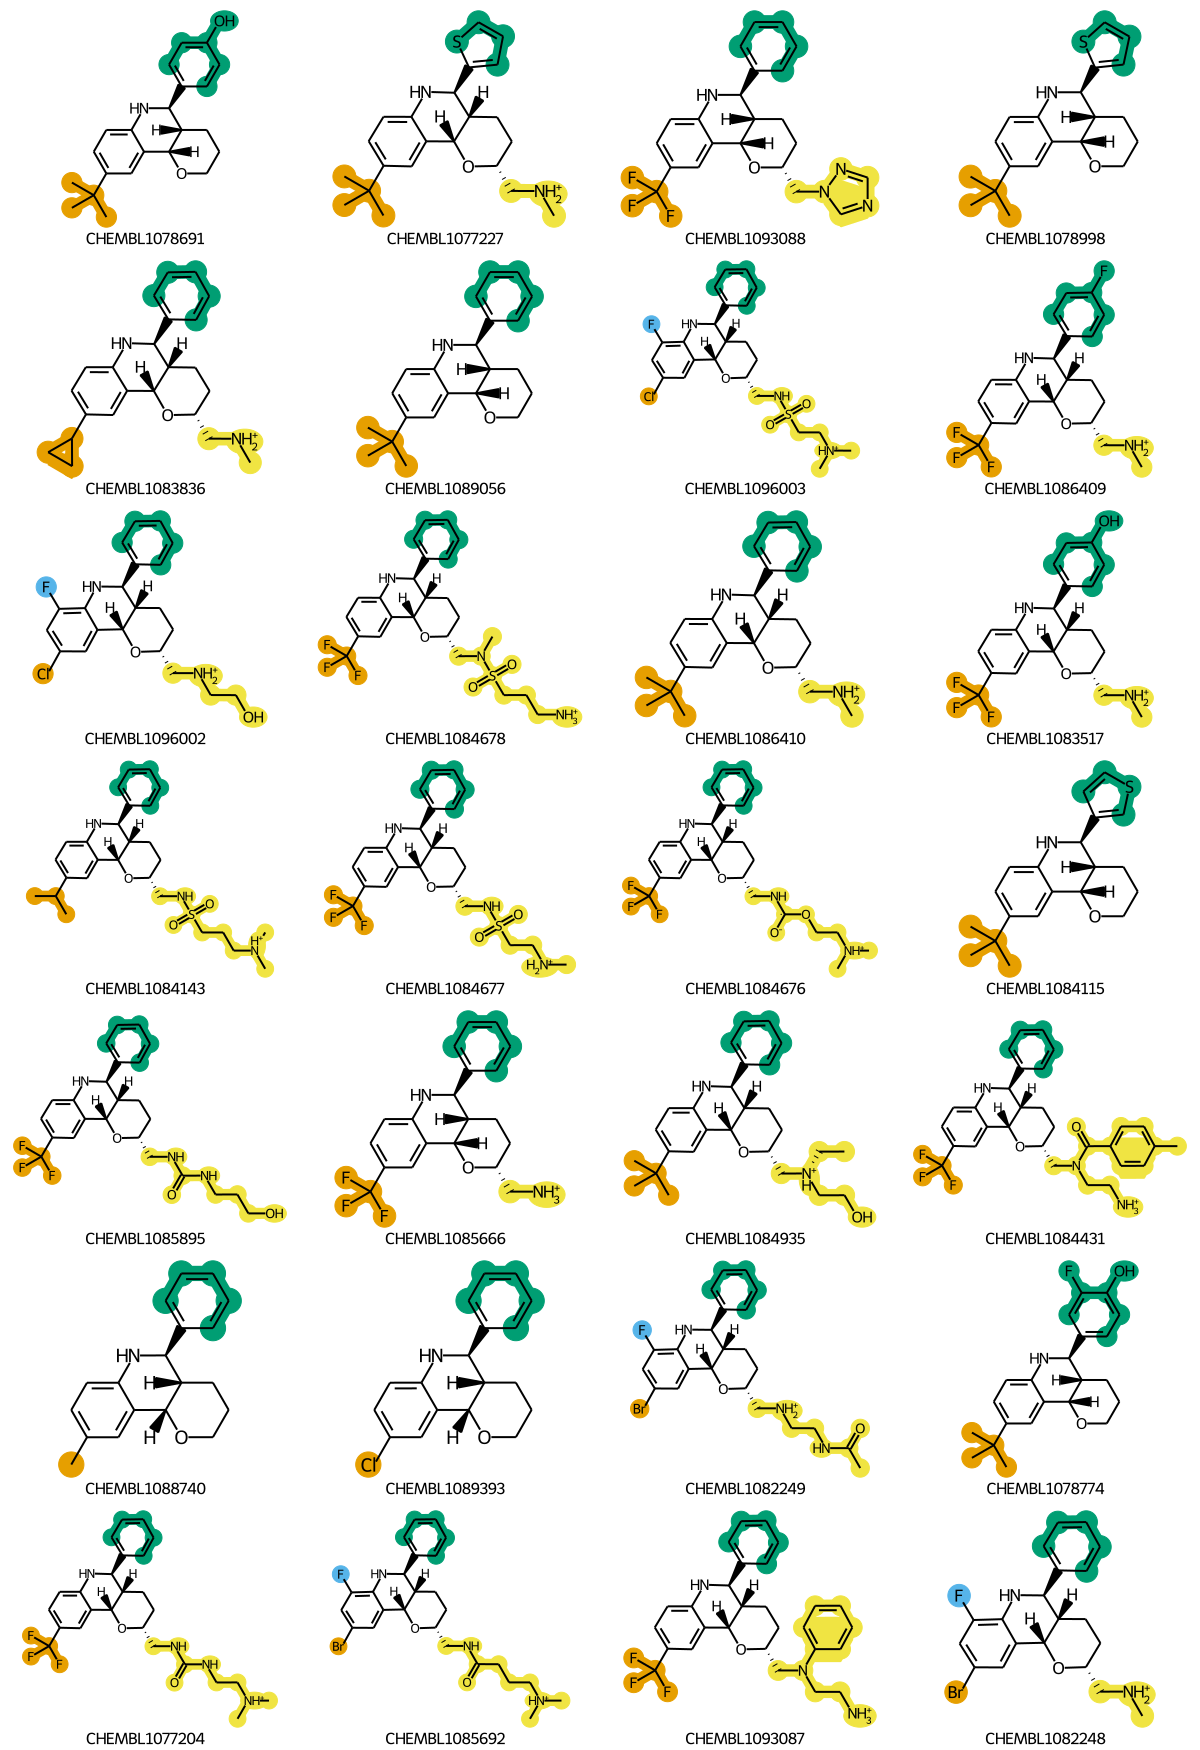

In [26]:
Image(draw_multiple(mms,groups,qcore,('R1','R2','R3','R4'),subImageSize=(300,250), legends=cids))


now grab the largest transformations from above, plot these transformations with the col

In [13]:
largest_transforms = sorted(transforms, key = lambda x: int(x[4]))[-30:]

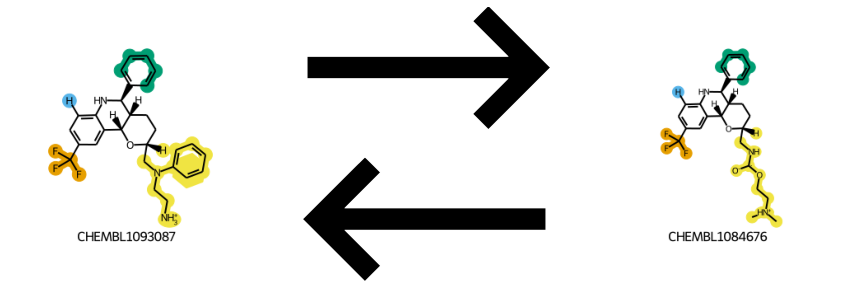

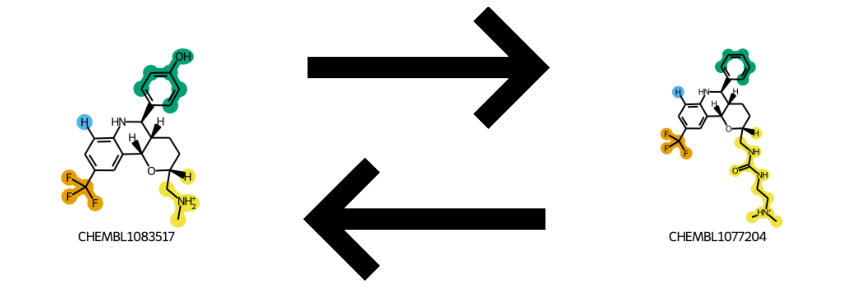

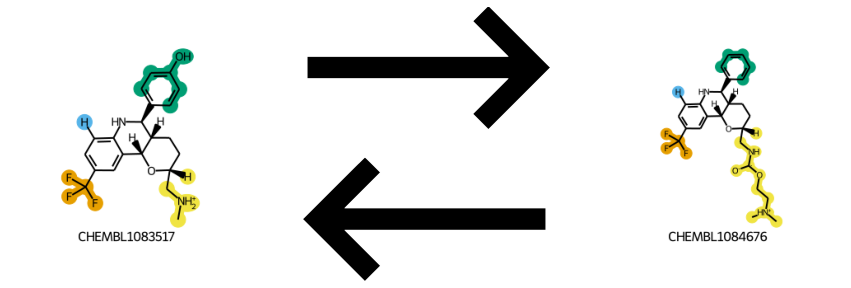

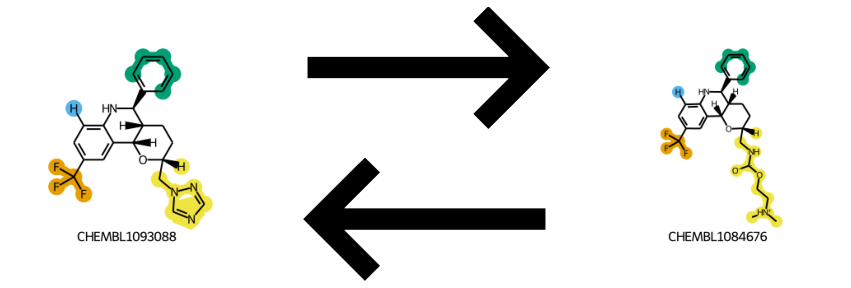

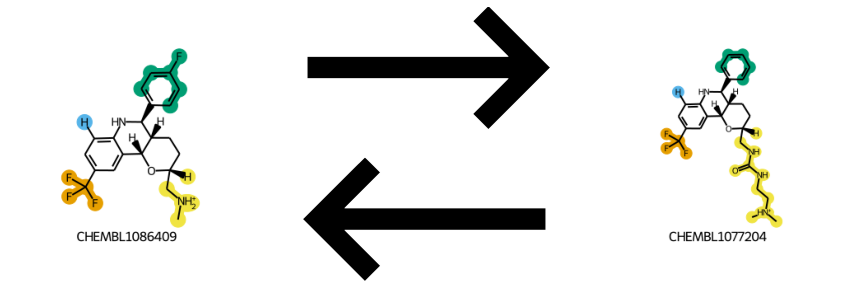

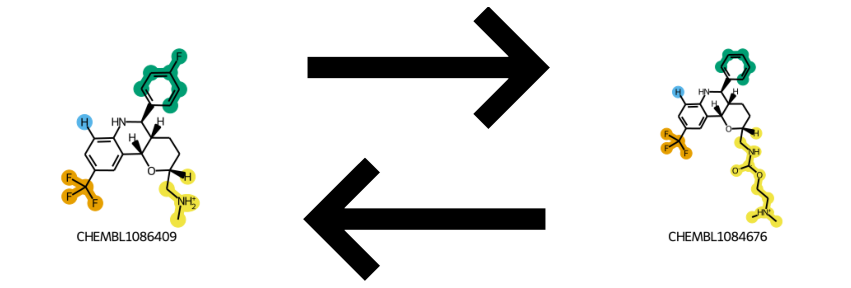

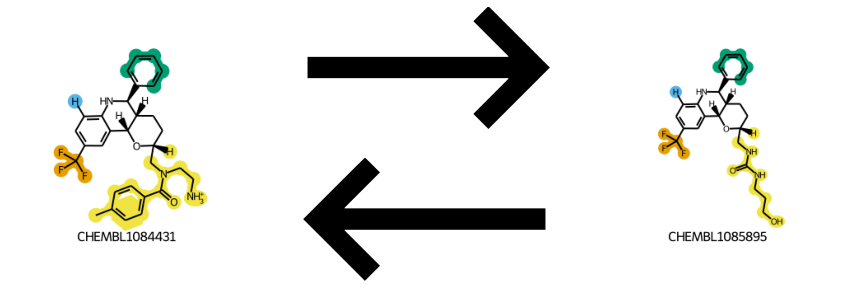

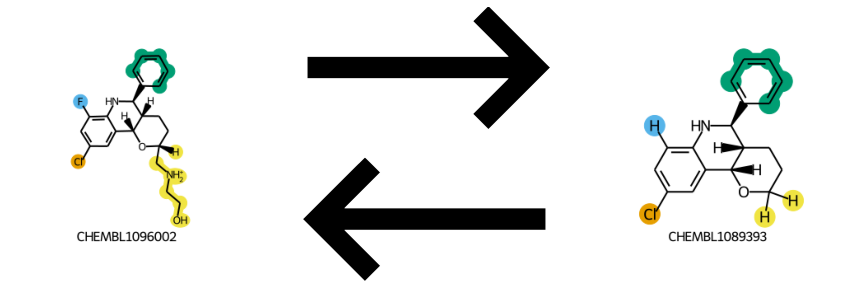

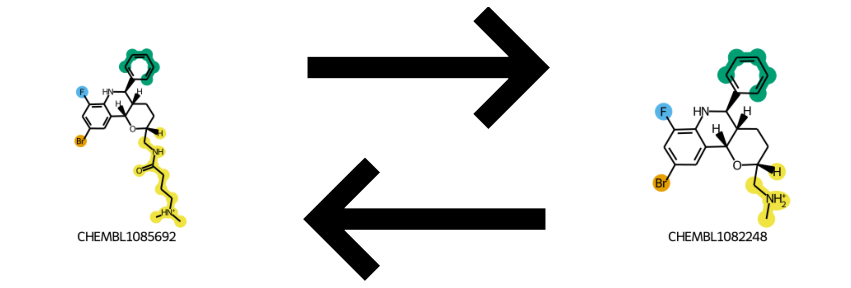

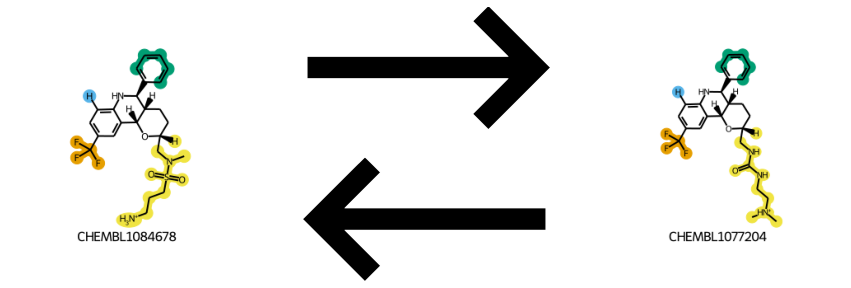

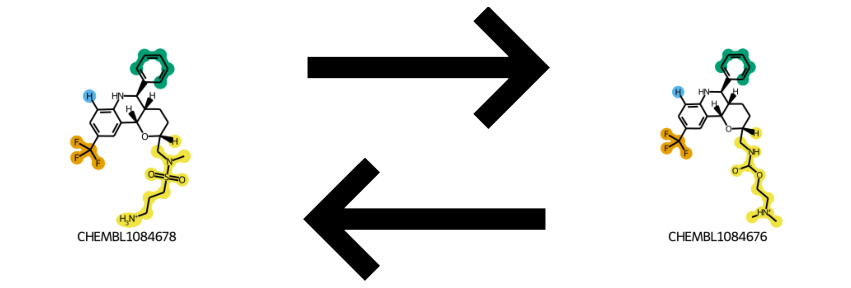

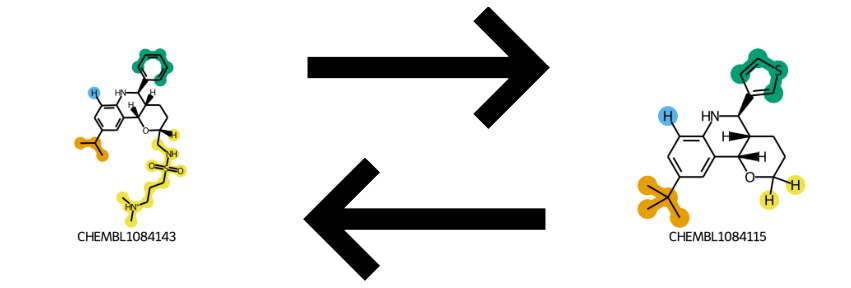

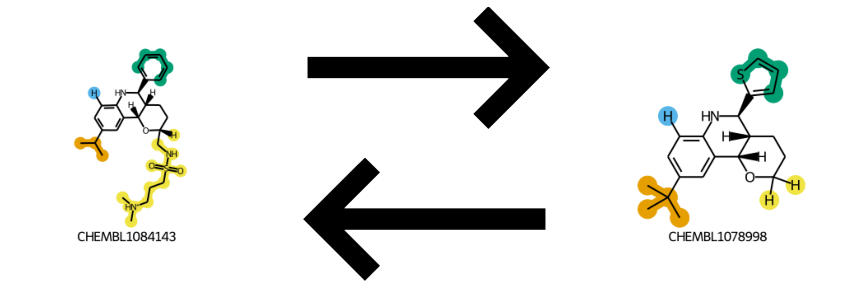

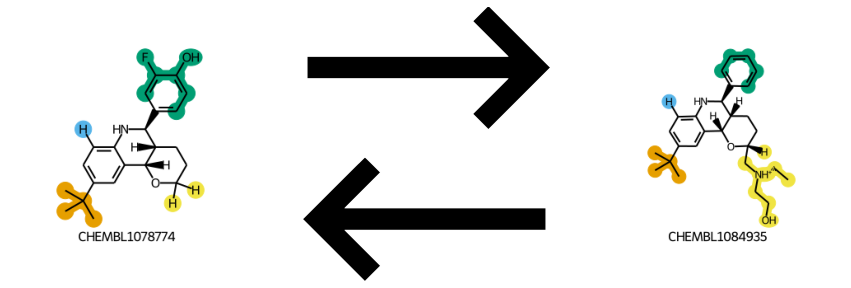

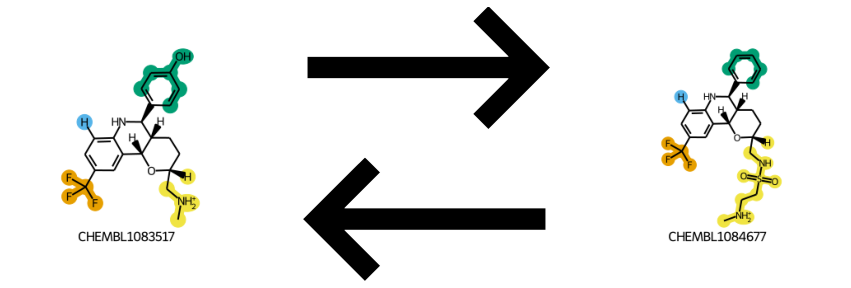

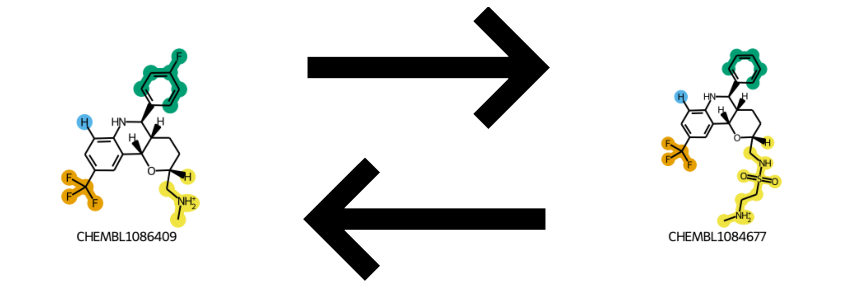

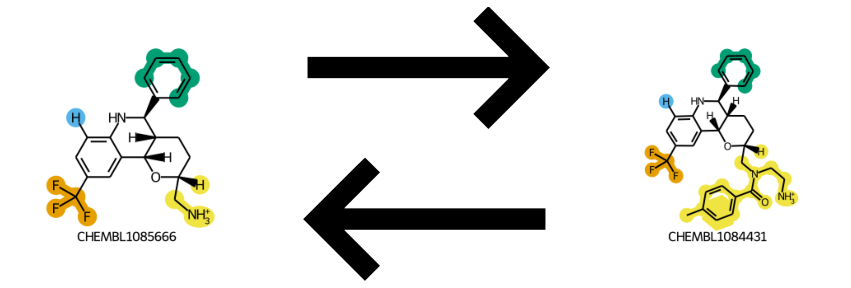

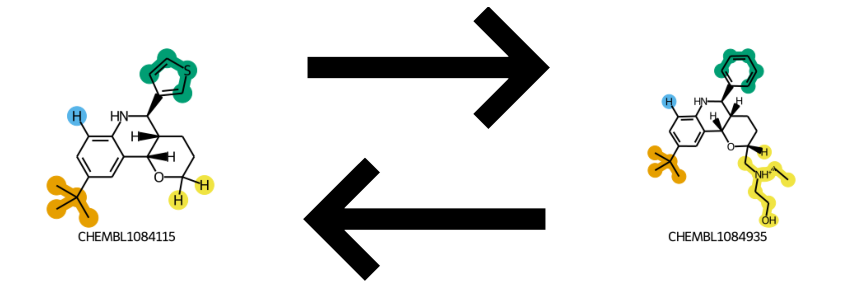

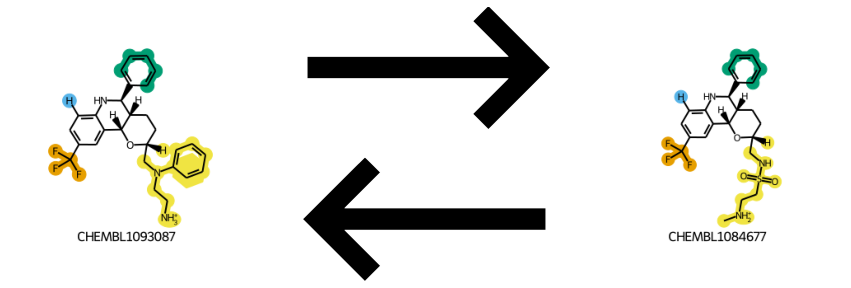

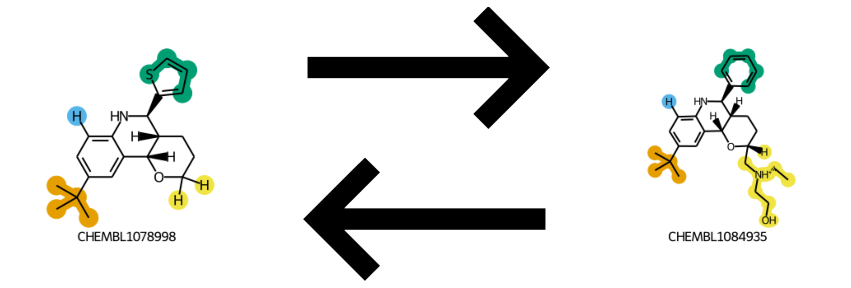

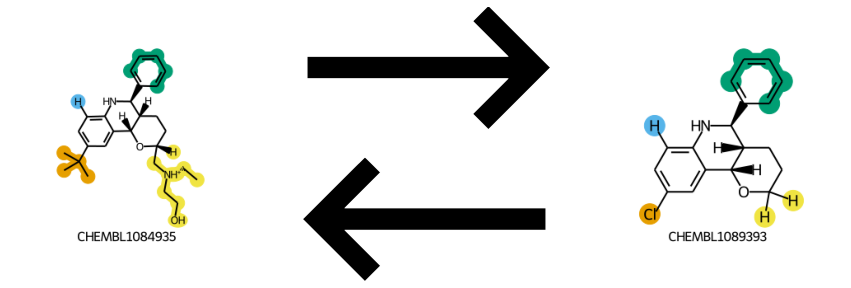

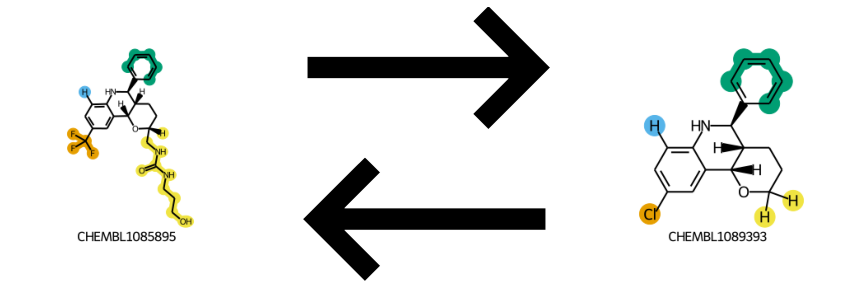

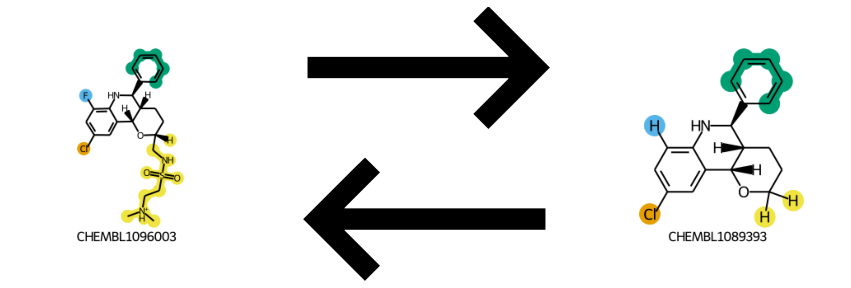

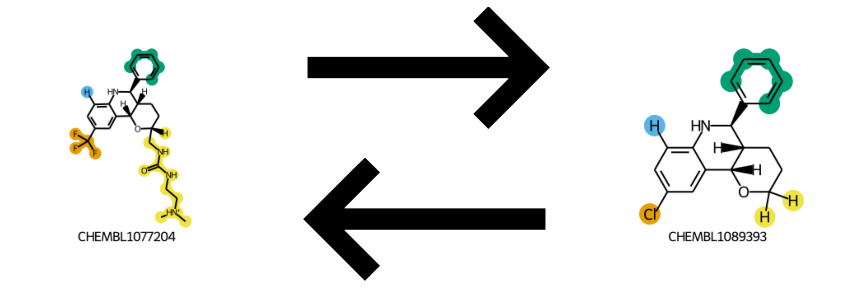

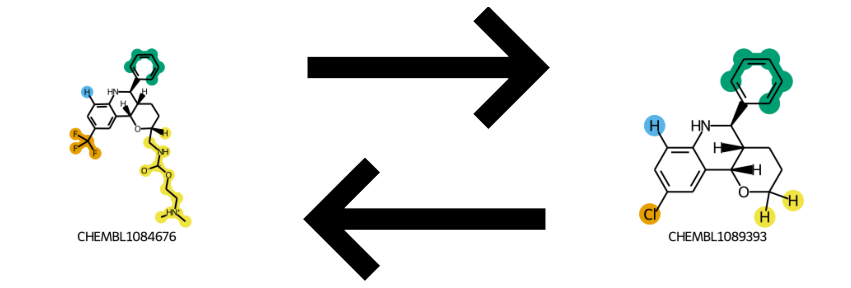

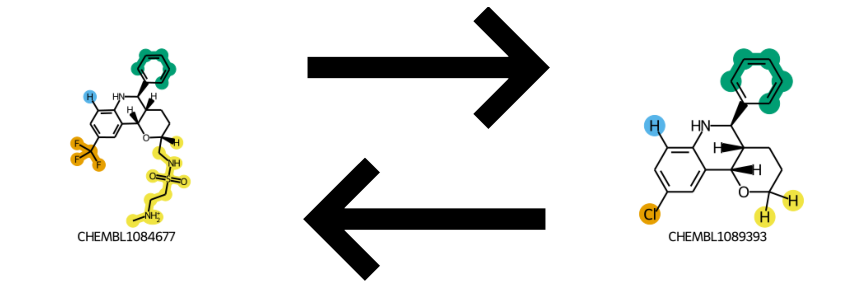

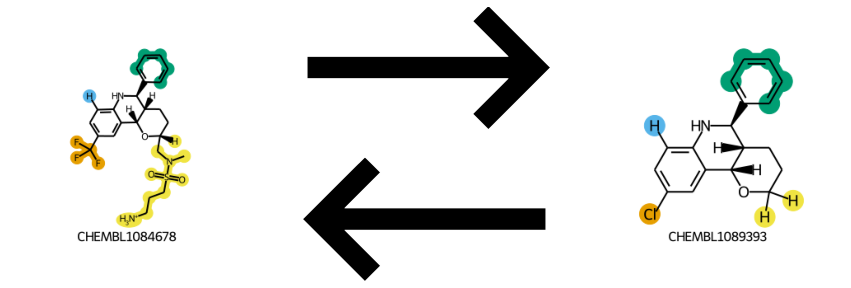

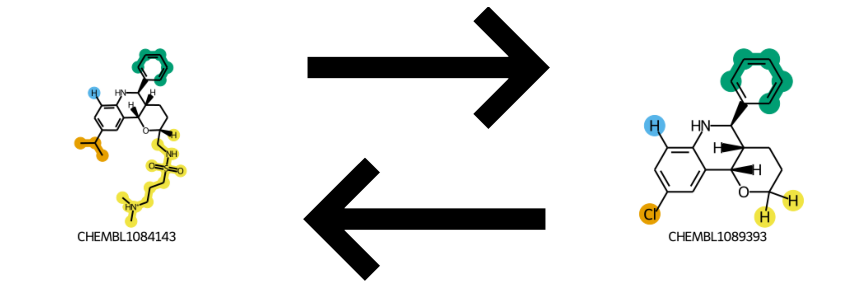

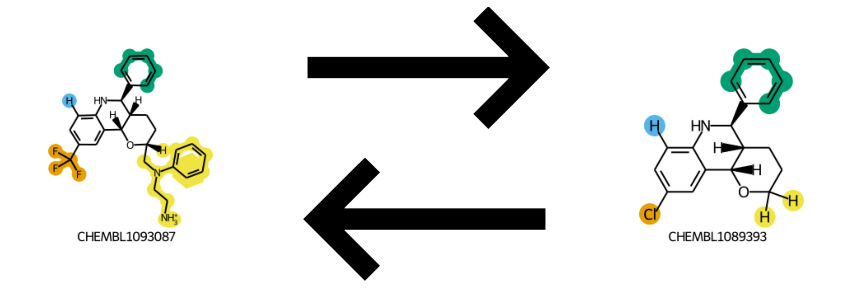

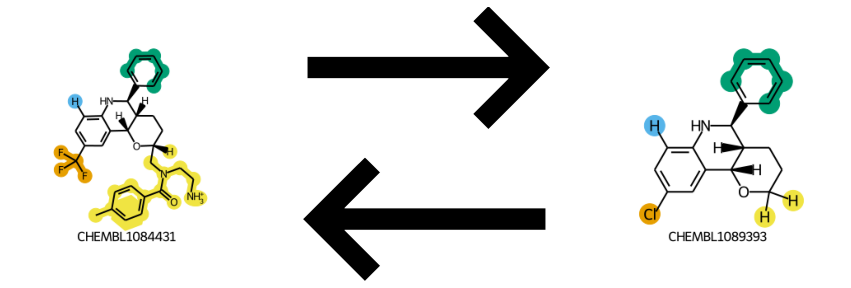

In [14]:
import matplotlib.image as mpimg 

for transform in largest_transforms:
    imgA = mpimg.imread(transform[2].replace(".pdb", ".png"))
    arrow = mpimg.imread("ligands/arrow.png")
    imgB = mpimg.imread(transform[3].replace(".pdb", ".png"))
    
    fig, ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(imgA)
    ax[1].imshow(arrow)
    ax[2].imshow(imgB)

    for axis in ax:
        axis.axis('off')

    plt.show()

Now figure out which transformations were done by Merck using FEP+: are they large enough for our use-case?

# FEP+ edges:

In [15]:
def count_n_perturbed(ligA_name, ligB_name):
    """given two molecule names, return number of atoms perturbed"""
    ligA = Chem.MolFromMol2File("ligands/"+ligA_name+"_1.mol2")
    ligB = Chem.MolFromMol2File("ligands/"+ligB_name+"_1.mol2")
    
    mcs = rdFMCS.FindMCS([ligA, ligB])

    fragA = Chem.ReplaceCore(ligA, Chem.MolFromSmarts(mcs.smartsString))
    fragB = Chem.ReplaceCore(ligB, Chem.MolFromSmarts(mcs.smartsString))
    
    fragA_smiles = Chem.MolToSmiles(fragA)
    fragB_smiles = Chem.MolToSmiles(fragB)

    def count_atoms(frags):
        """remove smiles notation to end up with only atoms in fragment and count them"""
        frags_list = [frag[4:].replace("[","").replace("]","") for frag in frags]
        frags_list = [ frag.replace("(", "").replace(")", "").replace("+", "").replace("-", "").replace(":","") \
                      for frag in frags_list ]
        all_frags = "".join(frags_list)
        frags_length = len(all_frags)
        return frags_length
        
        

    fragA_n_atoms = count_atoms(fragA_smiles.split("."))
    fragB_n_atoms = count_atoms(fragB_smiles.split("."))
    
    return max([fragA_n_atoms, fragB_n_atoms])
    

OSError: Bad input file ligands/CHEMBL1078774_1.mol2

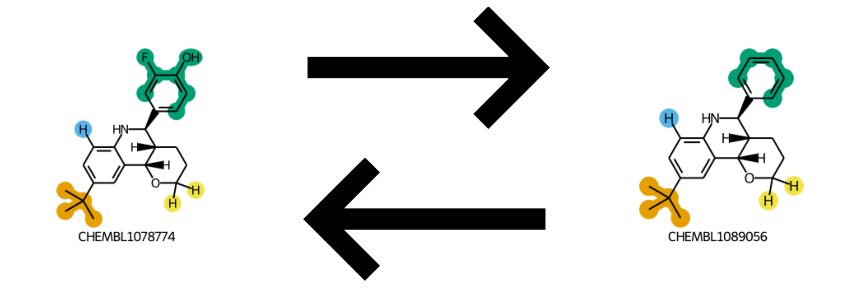

In [16]:
fep_plus_20ns = []
n_perturbed = []
with open("eg5/results_edges_20ns.csv") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for datapoint in reader:
        fep_plus_20ns.append(datapoint)
        imgA = mpimg.imread("ligands/"+datapoint[0]+".png")
        arrow = mpimg.imread("ligands/arrow.png")
        imgB = mpimg.imread("ligands/"+datapoint[1]+".png")

        fig, ax = plt.subplots(1,3, figsize=(15,15))
        ax[0].imshow(imgA)
        ax[1].imshow(arrow)
        ax[2].imshow(imgB)

        for axis in ax:
            axis.axis('off')
        n_perturbed.append(count_n_perturbed(datapoint[0], datapoint[1]))
        plt.show()

In [ ]:
# check correlation FEP+ vs exp:

fep = [ float(point[3]) for point in fep_plus_20ns ]
exp = [ float(point[2]) for point in fep_plus_20ns ]

#f, ax = plt.subplots(figsize=(10, 10))
plt.scatter(fep, exp, c=n_perturbed, cmap="jet")
cbar = plt.colorbar()
cbar.set_label('Number of perturbed heavy atoms')
    
plt.plot([-4, 4], [-4, 4], ls="--", color="black")
plt.plot([-4, 4], [-3, 5], ls="--", color="black")
plt.plot([-3, 4], [-4, 3], ls="--", color="black")


plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel("FEP+ predicted $\Delta$G / kcal$\cdot$mol$^{-1}$")
plt.ylabel("Experimental $\Delta$G / kcal$\cdot$mol$^{-1}$")

plt.show()
